# Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch
import torch.nn.functional as F
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.augmentations import ClassificationSMOTE
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

# Dataset Class

In [2]:
CAT_TO_NUM_LABELS = {
    "Normal traffic": 0,
    "Suspicious traffic": 1,
    "DDoS attack": 2,
}

class DDoSDataset(Dataset):
    def __init__(self, split):
        self.train_data_paths = [f'/home/appuser/data/train/SCLDDoS2024_SetA_events_extended.csv',
                                 f'/home/appuser/data/train/SCLDDoS2024_SetB_events_extended.csv']
        self.test_data_paths = [f'/home/appuser/data/test/SCLDDoS2024_SetC_events_extended.csv']     
        
        self.split = split   
        
        if split == 'train':
            self.features, self.lables = self.load_data(self.train_data_paths, apply_smote=False)
        elif split == 'test':
            self.features, self.lables = self.load_data(self.test_data_paths, apply_smote=False)
        else:
            print("Invalid split. Use 'train' or 'test'")
            
    
    def normalize(self, features):
        # Apply Min-Max Scaling to normalize the features between 0 and 1
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(features)
        return normalized_features
    
    def get_ports(self):
        return self.ddos_ports
    
    
    def get_data(self):
        return self.features.numpy(), self.lables.numpy()
        
        
    # preload the data as it makes the training much faster (and it easily fits in memory)
    def load_data(self, data_paths, apply_smote=False, undersample=True, sample_factor=4):
        data = []
        for path in data_paths:
            data.append(pd.read_csv(path).fillna(0))  # Read and fill NaNs with 0s
            
        df = pd.concat(data, ignore_index=True)  # Combine all dataframes
        
        self.ddos_ports = df[df['Type'] == "DDoS attack"]["Port number"].unique()
        
        #feature_columns = df.columns[:19]  # All except the last column
        feature_columns = df.columns[:-1]
        label_column = df.columns[-1]  # The last column
        
        # Convert categorical labels to numeric using the dictionary
        df[label_column] = df[label_column].map(CAT_TO_NUM_LABELS)
        
        # Check for missing or unknown labels
        if df[label_column].isna().any():
            print(df[label_column].isna().sum(), "missing labels")

        features = df[feature_columns].values
        labels = df[label_column].values
        
        # Normalize the features
        #features = self.normalize(features)
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)  # Classification requires long dtype
        
        
        
        if undersample and self.split == 'train':
            # Undersample the majority class (label=0)
            class_0_indices = np.where(labels.cpu().numpy() == 0)[0]
            class_1_indices = np.where(labels.cpu().numpy() == 1)[0]
            class_2_indices = np.where(labels.cpu().numpy() == 2)[0]

            # Randomly undersample the majority class
            num_class_0_samples = sample_factor*(len(class_1_indices) + len(class_2_indices))  # Same number as the minority class
            class_0_indices_undersampled = np.random.choice(class_0_indices, num_class_0_samples, replace=False)

            # Concatenate indices of class 1, 2, and undersampled class 0
            undersampled_indices = np.concatenate([class_0_indices_undersampled, class_1_indices, class_2_indices])

            # Subset the dataset to include only the sampled indices
            features = features[undersampled_indices]
            labels = labels[undersampled_indices]

        return features, labels


    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.lables[idx]

# Custom Loss Classes

In [3]:
class MacroF1(Metric):
    def __init__(self):
        super().__init__()
        self._name = "macro_f1"
        self._maximize = True

    def __call__(self, output, target):
        # Ensure output contains class labels (convert from probabilities if necessary)
        if output.ndim > 1:  # If output is multi-dimensional (probabilities)
            y_pred = np.argmax(output, axis=1)
        else:
            y_pred = output  # If output is already class labels
        
        # Convert target to class labels if it's one-hot encoded
        if target.ndim > 1:
            target = np.argmax(target, axis=1)
        
        # Compute the macro F1 score
        f1 = f1_score(target, y_pred, average='macro')
        return f1

class MacroAccuracy(Metric):
    def __init__(self):
        super().__init__()
        self._name = "macro_accuracy"
        self._maximize = True

    def __call__(self, output, target):
        # If output is a 1D array, just use argmax
        if output.ndim == 1:
            y_pred = output
        else:
            y_pred = np.argmax(output, axis=1)

        # Convert target to class labels if it's not already
        if target.ndim > 1:
            target = np.argmax(target, axis=1)

        cm = confusion_matrix(target, y_pred)
        per_class_acc = cm.diagonal() / cm.sum(axis=1)
        macro_acc = per_class_acc.mean()
        return macro_acc
    
class DynamicWeightCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights, max_epoch=500, increase_factor=3):
        super(DynamicWeightCrossEntropyLoss, self).__init__()
        self.initial_class_weights = class_weights
        self.class_weights = class_weights.clone()  # Start with initial weights
        self.max_epoch = max_epoch
        self.increase_factor = increase_factor
        self.increment_step = 100

    def forward(self, input, target, epoch):
        # Adjust weights based on epoch
        scaling_factor = self.increase_factor * int((epoch + 1) / self.increment_step) + 1
        adjusted_class_weights = self.initial_class_weights * scaling_factor
        
        # Make sure that weights do not grow too large (to avoid numerical instability)
        adjusted_class_weights = torch.clamp(adjusted_class_weights, max=100.0)
        
        # Apply the adjusted weights to the loss function
        loss_fn = nn.CrossEntropyLoss(weight=adjusted_class_weights)
        loss = loss_fn(input, target)
        return loss
    
    
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        alpha: Tensor of shape (num_classes,) or scalar. Use for class imbalance.
        gamma: Focusing parameter.
        """
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)  # [batch_size, num_classes]
        probs = torch.exp(log_probs)              # [batch_size, num_classes]

        # Gather the probs corresponding to the target class
        targets = targets.view(-1, 1)
        probs = probs.gather(1, targets).squeeze(1)     # [batch_size]
        log_probs = log_probs.gather(1, targets).squeeze(1)  # [batch_size]

        if self.alpha is not None:
            if isinstance(self.alpha, (list, torch.Tensor)):
                alpha_t = self.alpha[targets.squeeze()]
            else:
                alpha_t = self.alpha
            log_probs = alpha_t * log_probs

        focal_term = (1 - probs) ** self.gamma
        loss = -focal_term * log_probs

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # no reduction

# Training

In [12]:
run_name = "weights/TabNet_weighted_cross_entropy"

train_data = DDoSDataset('train')
X_train, y_train = train_data.get_data()

test_data = DDoSDataset('test')
X_test, y_test = test_data.get_data()


# best so far:
# p = 0.8, alpha = 0.3, beta = 0.3
# weights = [1.0, 3.0, 12.0]
# batch: 1024

smote_aug = ClassificationSMOTE(p=0.8, alpha=0.3, beta=0.3, seed=31)

class_weights = torch.tensor([1.0, 3.0, 12.0]).to("cuda")
gamma = 1.75
focal_loss = FocalLoss(gamma=gamma, alpha=class_weights)  

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

clf = TabNetClassifier(n_a=8, n_d=8,
                       n_steps=3, gamma=1.3,
                       n_independent=2, n_shared=2,
                       lambda_sparse=0.001,
                       optimizer_fn=torch.optim.AdamW,
                       optimizer_params=dict(lr=2e-2),
                       mask_type='entmax',  # "sparsemax"
                       scheduler_params={"step_size": 100, "gamma": 0.5},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=1,
                       seed = 31,
                       momentum=0.3,)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=[MacroAccuracy,MacroF1],
    max_epochs=50,
    patience=2000,
    batch_size=1024, virtual_batch_size=128,
    augmentations=smote_aug,
    loss_fn=loss_fn,
)

clf.save_model(run_name)

/home/appuser/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99005 | test_macro_accuracy: 0.36047 | test_macro_f1: 0.30722 |  0:00:04s
epoch 1  | loss: 0.63928 | test_macro_accuracy: 0.50537 | test_macro_f1: 0.51855 |  0:00:08s
epoch 2  | loss: 0.55719 | test_macro_accuracy: 0.36361 | test_macro_f1: 0.37519 |  0:00:12s
epoch 3  | loss: 0.55404 | test_macro_accuracy: 0.52992 | test_macro_f1: 0.60008 |  0:00:16s
epoch 4  | loss: 0.53817 | test_macro_accuracy: 0.45842 | test_macro_f1: 0.47994 |  0:00:21s
epoch 5  | loss: 0.50926 | test_macro_accuracy: 0.36493 | test_macro_f1: 0.37594 |  0:00:25s
epoch 6  | loss: 0.49159 | test_macro_accuracy: 0.43124 | test_macro_f1: 0.43529 |  0:00:29s
epoch 7  | loss: 0.4979  | test_macro_accuracy: 0.54299 | test_macro_f1: 0.5992  |  0:00:33s
epoch 8  | loss: 0.48131 | test_macro_accuracy: 0.38221 | test_macro_f1: 0.40122 |  0:00:37s
epoch 9  | loss: 0.4777  | test_macro_accuracy: 0.43743 | test_macro_f1: 0.46511 |  0:00:41s
epoch 10 | loss: 0.47561 | test_macro_accuracy: 0.61119 | test_macro_f

/home/appuser/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at weights/TabNet_weighted_cross_entropy.zip


'weights/TabNet_weighted_cross_entropy.zip'

# Testing

/home/appuser/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Accuracy: 0.9303

Classification Report:
               precision    recall  f1-score        support
0              0.997845  0.938114  0.967058  125892.000000
1              0.964762  0.663827  0.786491    3052.000000
2              0.085193  0.770616  0.153425    1055.000000
accuracy       0.930315  0.930315  0.930315       0.930315
macro avg      0.682600  0.790852  0.635658  129999.000000
weighted avg   0.989662  0.930315  0.956216  129999.000000

F1 (Micro): 0.9303
F1 (Macro): 0.6357

Class-wise Accuracy (Recall):
 0    0.938114
1    0.663827
2    0.770616
Name: recall, dtype: float64


<Figure size 800x600 with 0 Axes>

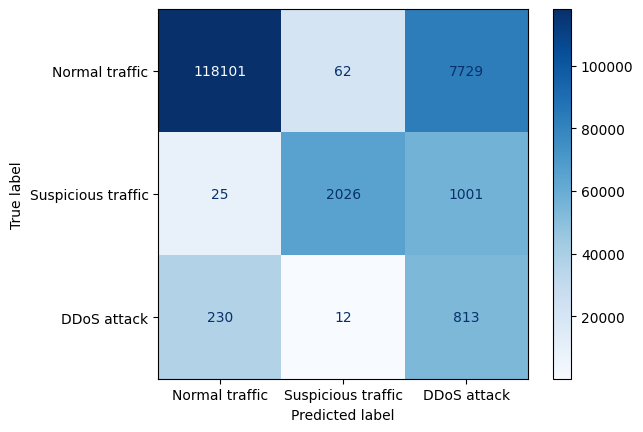

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

clf = TabNetClassifier()
clf.load_model(f"{run_name}.zip")

y_pred = clf.predict(X_test)

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (includes precision, recall, F1 per class + macro/micro)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:\n", report_df)

# F1 scores
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"\nF1 (Micro): {f1_micro:.4f}")
print(f"F1 (Macro): {f1_macro:.4f}")

# Class-wise accuracy (same as recall per class)
class_wise_accuracy = report_df.loc[[str(i) for i in np.unique(y_test)], "recall"]
print("\nClass-wise Accuracy (Recall):\n", class_wise_accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal traffic", "Suspicious traffic", "DDoS attack"])
disp.plot(cmap='Blues', values_format="d")
plt.imshow(np.log1p(conf_matrix), cmap='Blues')  # Log transform for better visualization
plt.show()
